In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Feger/suger-pie-honey-pot

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Feger/suger-pie-honey-pot


In [2]:
! pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Requirements

In [3]:
import pandas as pd
import numpy as np
import torch
import json
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# prepare data
df_majority_votes = pd.read_csv('./annotations/final/majority_votes.csv', index_col="Unnamed: 0")
df_majority_votes["convincing"] = df_majority_votes["convincing"].astype(int)
df_samples = pd.read_excel('./annotations/samples.xlsx')
df_generated_samples = pd.read_excel('./annotations/queried_samples.xlsx')

assert sorted(df_majority_votes["request-id"]) == sorted(df_samples["request-id"])
# merge session information to majority votes
df_majority_votes = df_majority_votes.merge(df_samples[["request-id", "session", "session-id"]], on = "request-id")
df_majority_votes = df_majority_votes.merge(df_generated_samples[['request-id', 'true-response', 'generated-response']], on='request-id')
df_majority_votes = df_majority_votes.fillna('')

# Transition Probabilities

In [5]:
def calculate_transition_probabilities(data):
    # init transitions
    transitions = {'0 -> 0': 0, '0 -> 1': 0, '1 -> 0': 0, '1 -> 1': 0}
    total_transitions = {'0': 0, '1': 0}

    # group data by session
    session_groups = data.groupby('session')

    for name, group in session_groups:
        # sort the session to have the correct order
        sorted_group = group.sort_values('session-id')
        # count transitions
        for i in range(len(sorted_group) - 1):
            current_state = str(sorted_group.iloc[i]['convincing'])
            next_state = str(sorted_group.iloc[i + 1]['convincing'])
            transition = f"{current_state} -> {next_state}"
            transitions[transition] += 1
            total_transitions[current_state] += 1

    # calculate the probabilities for transitions
    transition_probabilities = {}
    for transition, count in transitions.items():
        from_state = transition.split(' -> ')[0]
        if total_transitions[from_state] > 0:
            transition_probabilities[transition] = round((count / total_transitions[from_state])*100, 2)
        else:
            transition_probabilities[transition] = 0

    return transition_probabilities

def print_transitions(data):
    false_to_false = data["0 -> 0"]
    false_to_true = data["0 -> 1"]
    true_to_false = data["1 -> 0"]
    true_to_true = data["1 -> 1"]

    output = f"""
    p(s+1|s)       | Not Believable | Believable
    --------------------------------------------
    Not Believable | {false_to_false}%         | {false_to_true}%
    Believable     | {true_to_false}%         | {true_to_true}%
    """

    print(output)

In [6]:
data = df_majority_votes[df_majority_votes["session"] != -1]

transition_probabilities = calculate_transition_probabilities(data)
print_transitions(transition_probabilities)


    p(s+1|s)       | Not Believable | Believable
    --------------------------------------------
    Not Believable | 49.04%         | 50.96%
    Believable     | 40.41%         | 59.59%
    


# Similarity

In [7]:
def cosine_distance_score(x1, x2):
    return 1 - cosine_similarity([x1], [x2])[0][0]

### Classification by Similarity

In [8]:
def classify_by_cosine_distance(df, threshold, all_true_embeddings, all_generated_embeddings):
    # Initialize storage for predictions and labels
    all_predictions = []
    all_labels = df['convincing'].values

    # Calculate cosine distances and classify based on threshold
    for true_emb, gen_emb in zip(all_true_embeddings, all_generated_embeddings):
        cosine_dist = cosine_distance_score(true_emb, gen_emb)
        pred = 1 if cosine_dist <= threshold else 0
        all_predictions.append(pred)

    return all_predictions, all_labels

def get_best_f1(df, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SentenceTransformer(model_name, device=device)

    # Precompute embeddings for all data
    all_true_embeddings = model.encode(list(df['true-response']), device=device)
    all_generated_embeddings = model.encode(list(df['generated-response']), device=device)

    # Initialize variables to track the best F1 score and corresponding threshold
    best_f1 = 0
    best_threshold = None
    reports = dict()
    thresholds = np.arange(0, 1.05, 0.05)  # Using a finer step size for more precise threshold tuning

    # Iterate over possible thresholds and evaluate the classification performance
    for threshold in tqdm(thresholds):
        threshold = round(threshold, 2)
        predictions, labels = classify_by_cosine_distance(df, threshold, all_true_embeddings, all_generated_embeddings)
        report = classification_report(labels, predictions, output_dict=True, zero_division=0, target_names=["Not Convincing", "Convincing"])
        f1_score = report['macro avg']['f1-score']
        reports[threshold] = report
        if f1_score > best_f1:
            best_f1 = f1_score
            best_threshold = threshold

    print(f'Model: {model_name}')
    print(f"Best macro avg. F1 score: {best_f1} found at Threshold: {round(best_threshold, 2)}")
    print(json.dumps(reports[best_threshold], indent=4, sort_keys=True))

In [9]:
get_best_f1(df_majority_votes, 'all-MiniLM-L6-v2')
get_best_f1(df_majority_votes, 'bert-base-uncased')
get_best_f1(df_majority_votes, 'distilbert-base-uncased')
get_best_f1(df_majority_votes, 'roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Model: all-MiniLM-L6-v2
Best macro avg. F1 score: 0.7784836502983299 found at Threshold: 0.4
{
    "Convincing": {
        "f1-score": 0.7633587786259541,
        "precision": 0.8695652173913043,
        "recall": 0.6802721088435374,
        "support": 735
    },
    "Not Convincing": {
        "f1-score": 0.7936085219707057,
        "precision": 0.717208182912154,
        "recall": 0.8882265275707899,
        "support": 671
    },
    "accuracy": 0.7795163584637269,
    "macro avg": {
        "f1-score": 0.7784836502983299,
        "precision": 0.7933867001517292,
        "recall": 0.7842493182071637,
        "support": 1406
    },
    "weighted avg": {
        "f1-score": 0.7777951781880653,
        "precision": 0.7968542855737296,
        "recall": 0.7795163584637269,
        "support": 1406
    }
}


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Model: bert-base-uncased
Best macro avg. F1 score: 0.7536376477319457 found at Threshold: 0.15
{
    "Convincing": {
        "f1-score": 0.7292817679558011,
        "precision": 0.868421052631579,
        "recall": 0.6285714285714286,
        "support": 735
    },
    "Not Convincing": {
        "f1-score": 0.7779935275080905,
        "precision": 0.6876430205949656,
        "recall": 0.8956780923994039,
        "support": 671
    },
    "accuracy": 0.7560455192034139,
    "macro avg": {
        "f1-score": 0.7536376477319457,
        "precision": 0.7780320366132722,
        "recall": 0.7621247604854162,
        "support": 1406
    },
    "weighted avg": {
        "f1-score": 0.75252898748609,
        "precision": 0.7821464726197954,
        "recall": 0.7560455192034139,
        "support": 1406
    }
}


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Model: distilbert-base-uncased
Best macro avg. F1 score: 0.7515248283079439 found at Threshold: 0.1
{
    "Convincing": {
        "f1-score": 0.7237790232185748,
        "precision": 0.8793774319066148,
        "recall": 0.6149659863945578,
        "support": 735
    },
    "Not Convincing": {
        "f1-score": 0.779270633397313,
        "precision": 0.6827354260089686,
        "recall": 0.9076005961251863,
        "support": 671
    },
    "accuracy": 0.7546230440967283,
    "macro avg": {
        "f1-score": 0.7515248283079439,
        "precision": 0.7810564289577917,
        "recall": 0.761283291259872,
        "support": 1406
    },
    "weighted avg": {
        "f1-score": 0.7502618613621973,
        "precision": 0.7855319226908818,
        "recall": 0.7546230440967283,
        "support": 1406
    }
}


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Model: roberta-base
Best macro avg. F1 score: 0.6796365823468192 found at Threshold: 0.05
{
    "Convincing": {
        "f1-score": 0.7179161372299874,
        "precision": 0.6734207389749702,
        "recall": 0.7687074829931972,
        "support": 735
    },
    "Not Convincing": {
        "f1-score": 0.6413570274636511,
        "precision": 0.7001763668430335,
        "recall": 0.5916542473919523,
        "support": 671
    },
    "accuracy": 0.6842105263157895,
    "macro avg": {
        "f1-score": 0.6796365823468192,
        "precision": 0.6867985529090019,
        "recall": 0.6801808651925747,
        "support": 1406
    },
    "weighted avg": {
        "f1-score": 0.6813790371921412,
        "precision": 0.6861896054753048,
        "recall": 0.6842105263157895,
        "support": 1406
    }
}


### Best Classifier Similarity Distribution

In [10]:
def percent_data_in_threshold(scores, label, threshold, below=False):
    data_with_label = [item for item in scores if item[0] == label]
    if below:
        data_threshold = [item for item in data_with_label if item[1] <= threshold]
    else:
        data_threshold = [item for item in data_with_label if item[1] >= threshold]
    return round((len(data_threshold)/len(data_with_label))*100, 2)

In [13]:
def show_distribution(df, model_type, threshold, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Initialize the SentenceTransformer model with CUDA
    model = SentenceTransformer(model_type, device=device)

    # Preparing the data
    sentence_pairs = df[['convincing', 'true-response', 'generated-response']].values

    # Storage for scores
    scores = []

    # Process sentence pairs and compute cosine similarity
    for label, sentence1, sentence2 in tqdm(sentence_pairs):
        # Encode the sentences to get their embeddings
        embedding1 = model.encode(sentence1, device=device)
        embedding2 = model.encode(sentence2, device=device)

        # Calculate cosine similarity and convert it to distance
        similarity = cosine_distance_score(embedding1, embedding2)
        scores.append([label, similarity])

    # Create a DataFrame from the scores
    df_ = pd.DataFrame(scores, columns=['Label', 'Distance'])

    # Plot using Seaborn
    plt.figure(figsize=(11, 6))
    sns.kdeplot(data=df_, x='Distance', hue='Label', fill=True, common_norm=True, palette=['blue', 'red'], alpha=0.5)
    plt.title(f'Density Plot of Cosine Distances for {model_type}')
    plt.xlabel('Cosine Distance')
    plt.xlim(0, 1.2)
    plt.ylabel('')
    plt.yticks([])
    plt.legend(title='Label', labels=["Convincing", "Not Convincing"])
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
    plt.text(0.29, threshold, str(percent_data_in_threshold(scores, 1, threshold, below=True))+"%", color='red', fontsize=12,  va='center')
    plt.text(0.47, threshold, str(percent_data_in_threshold(scores, 0, threshold, below=False))+"%", color='blue', fontsize=12, va='center')
    plt.savefig(save_path, format='svg')
    plt.show()

  0%|          | 0/1406 [00:00<?, ?it/s]

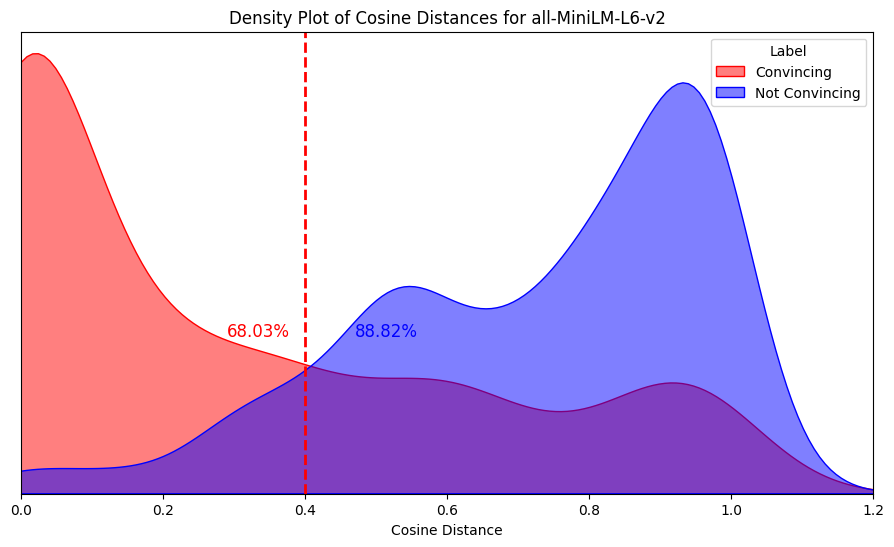

In [14]:
show_distribution(df_majority_votes, 'all-MiniLM-L6-v2', 0.4, './data/outputs/density.svg')